**Objectif** : Explorer et préparer les données brutes pour l’analyse métier et la modélisation.
- Chargement du dataset bancaire réel.
- Analyse exploratoire simple (EDA) : statistiques, visualisations business, compréhension des variables.
- Création et export de jeux de données et de sous-ensembles utiles pour la suite (modélisation).

**Données utilisées** : `bank-additional-full.csv` (fichier CSV fourni).

**Comment utiliser ce notebook** :
- Exécuter toutes les cellules dans l’ordre (Kernel Python 3 recommandé).
- Les résultats, CSV et graphiques sont générés dans le dossier `outputs/`.
- Le dataset final prêt pour la modélisation est `outputs/up_data.csv`.

**Sorties principales** :
- Tableaux : `columns_summary.csv`, `profil_cols.csv`, `campagne_cols.csv`, `macro_cols.csv`
- Graphiques PNG pour chaque analyse business

**Remarque** :
Ce notebook est structuré par étapes : import, chargement, exploration, feature engineering, visualisations. Chaque cellule est commentée simplement pour faciliter la compréhension.

2. Imports & setup


In [28]:
import os
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Librairies utiles pour la suite (scikit-learn pour preprocessing / modeling dans Projet 2)
import sklearn

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Contexte : ce notebook est placé dans le dossier du projet. Path.cwd() renvoie ce dossier lorsque
# vous lancez le notebook depuis l'interface (VS Code / Jupyter).
PROJECT_ROOT = Path(os.getcwd())
NOTEBOOK_DIR = PROJECT_ROOT
OUT_DIR = NOTEBOOK_DIR / 'outputs'
PLOTS_DIR = OUT_DIR / 'plots'
PLOTS_DIR.mkdir(exist_ok=True)
OUT_DIR.mkdir(exist_ok=True)

# Options d'affichage pandas pour faciliter l'exploration
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 160)

print('Notebook dir:', NOTEBOOK_DIR)
print('Outputs folder:', OUT_DIR)
print('Plots folder:', PLOTS_DIR)


Notebook dir: c:\Users\ahmed\OneDrive\Desktop\projets\projet_data\Projet 1 - Data Cleaning
Outputs folder: c:\Users\ahmed\OneDrive\Desktop\projets\projet_data\Projet 1 - Data Cleaning\outputs
Plots folder: c:\Users\ahmed\OneDrive\Desktop\projets\projet_data\Projet 1 - Data Cleaning\outputs\plots


3. Chargement des données

In [10]:
data_path = PROJECT_ROOT / "data/bank-additional-full.csv"
df = pd.read_csv(data_path, sep=None, engine='python')
df['id'] = df.index + 1  # Ajouter une colonne ID

# Aperçu
display(df.head())
print(df.info())
print(df.describe())


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,id
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,3
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,4
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

4. Résumé des colonnes

In [11]:
# Générer un tableau de synthèse des colonnes
cols_summary = [
    {'col': 'age', 'dtype': 'int', 'utilité': 'Âge du client', 'importance': 'Forte'},
    {'col': 'job', 'dtype': 'cat', 'utilité': 'Profession', 'importance': 'Moyenne à forte'},
    {'col': 'marital', 'dtype': 'cat', 'utilité': 'Statut marital', 'importance': 'Moyenne'},
    {'col': 'education', 'dtype': 'cat', 'utilité': 'Niveau éducation', 'importance': 'Moyenne'},
    {'col': 'default', 'dtype': 'cat', 'utilité': 'Historique défaut paiement', 'importance': 'Forte'},
    {'col': 'housing', 'dtype': 'cat', 'utilité': 'Crédit immobilier', 'importance': 'Moyenne'},
    {'col': 'loan', 'dtype': 'cat', 'utilité': 'Prêt personnel', 'importance': 'Moyenne'},
    {'col': 'contact', 'dtype': 'cat', 'utilité': 'Canal de communication', 'importance': 'Faible à moyenne'},
    {'col': 'month', 'dtype': 'cat', 'utilité': 'Mois du contact', 'importance': 'Faible à moyenne'},
    {'col': 'day_of_week', 'dtype': 'cat', 'utilité': 'Jour de la semaine', 'importance': 'Faible à moyenne'},
    {'col': 'duration', 'dtype': 'int', 'utilité': 'Durée appel (sec)', 'importance': 'Très forte (fuite ?)'},
    {'col': 'campaign', 'dtype': 'int', 'utilité': 'Nombre contacts campagne', 'importance': 'Moyenne'},
    {'col': 'pdays', 'dtype': 'int', 'utilité': 'Jours depuis dernier contact', 'importance': 'Moyenne'},
    {'col': 'previous', 'dtype': 'int', 'utilité': 'Nombre contacts antérieurs', 'importance': 'Moyenne'},
    {'col': 'poutcome', 'dtype': 'cat', 'utilité': 'Résultat campagne précédente', 'importance': 'Forte'},
    {'col': 'emp.var.rate', 'dtype': 'float', 'utilité': 'Taux variation emploi', 'importance': 'Macro'},
    {'col': 'cons.price.idx', 'dtype': 'float', 'utilité': 'Indice prix consommation', 'importance': 'Macro'},
    {'col': 'cons.conf.idx', 'dtype': 'float', 'utilité': 'Indice confiance consommateurs', 'importance': 'Macro'},
    {'col': 'euribor3m', 'dtype': 'float', 'utilité': 'Taux Euribor 3m', 'importance': 'Macro'},
    {'col': 'nr.employed', 'dtype': 'float', 'utilité': 'Nombre employés', 'importance': 'Macro'},
    {'col': 'y', 'dtype': 'cat', 'utilité': 'CIBLE: Souscription oui/non', 'importance': 'Très forte'}
]

cols_df = pd.DataFrame(cols_summary)
cols_df.to_csv(OUT_DIR / 'columns_summary.csv', index=False)
display(cols_df)


,col,dtype,utilité,importance
0,age,int,Âge du client,Forte
1,job,cat,Profession,Moyenne à forte
2,marital,cat,Statut marital,Moyenne
3,education,cat,Niveau éducation,Moyenne
4,default,cat,Historique défaut paiement,Forte
5,housing,cat,Crédit immobilier,Moyenne
6,loan,cat,Prêt personnel,Moyenne
7,contact,cat,Canal de communication,Faible à moyenne
8,month,cat,Mois du contact,Faible à moyenne
9,day_of_week,cat,Jour de la semaine,Faible à moyenne


5. Découpage par groupes de colonnes

In [12]:
profil_cols = ['id','age','job','marital','education','default','housing','loan']
campagne_cols = ['id','contact','month','day_of_week','duration','campaign','pdays','previous','poutcome','y']
macro_cols = ['id','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

df_profil = df[profil_cols].copy()
df_campagne = df[campagne_cols].copy()
df_macro = df[macro_cols].copy()

# Export CSVs
df_profil.to_csv(OUT_DIR / 'profil_cols.csv', index=False)
df_campagne.to_csv(OUT_DIR / 'campagne_cols.csv', index=False)
df_macro.to_csv(OUT_DIR / 'macro_cols.csv', index=False)
print("CSV files exported to", OUT_DIR)

CSV files exported to c:\Users\ahmed\OneDrive\Desktop\projets\projet_data\Projet 1 - Data Cleaning\outputs


6. Feature Engineering

In [ ]:
df_fe = df.copy()

# Binning âge
age_bins = [0, 25, 35, 50, 65, 120]
age_labels = ['<25','25-34','35-49','50-64','65+']
df_fe['age_bin'] = pd.cut(df_fe['age'], bins=age_bins, labels=age_labels, include_lowest=True)



# Mois 
month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
df_fe['month_num'] = df_fe['month'].map(month_map)

# Variable cible binaire
df_fe['y_bin'] = df_fe['y'].map({'yes':1,'no':0})



6. Visualisation Exploratoire (Business Understanding)

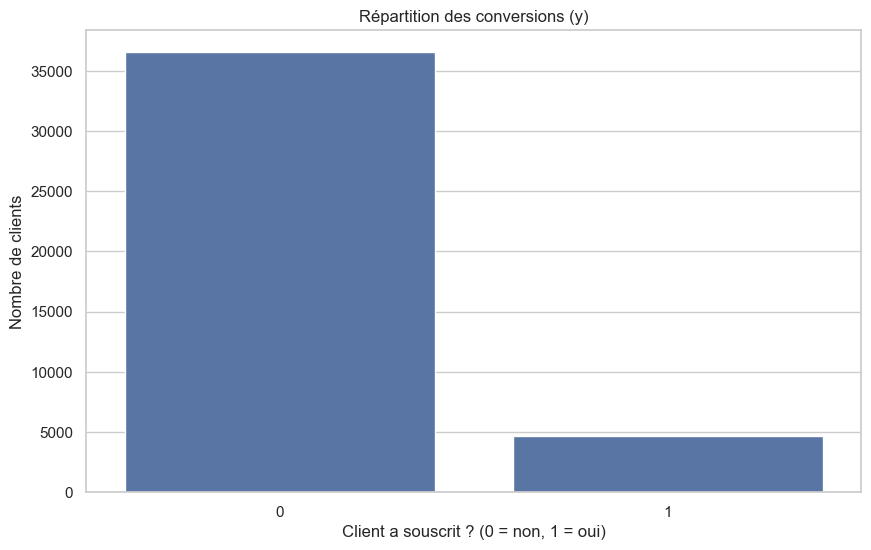

In [29]:
# 1. Répartition cible (conversion)
dt = df_fe.copy()
plt.figure()
sns.countplot(data=dt, x='y_bin')
plt.title("Répartition des conversions (y)")
plt.xlabel("Client a souscrit ? (0 = non, 1 = oui)")
plt.ylabel("Nombre de clients")
plt.savefig(PLOTS_DIR / "Répartition_des_conversions_(y).png", dpi=300, bbox_inches='tight')
plt.show()


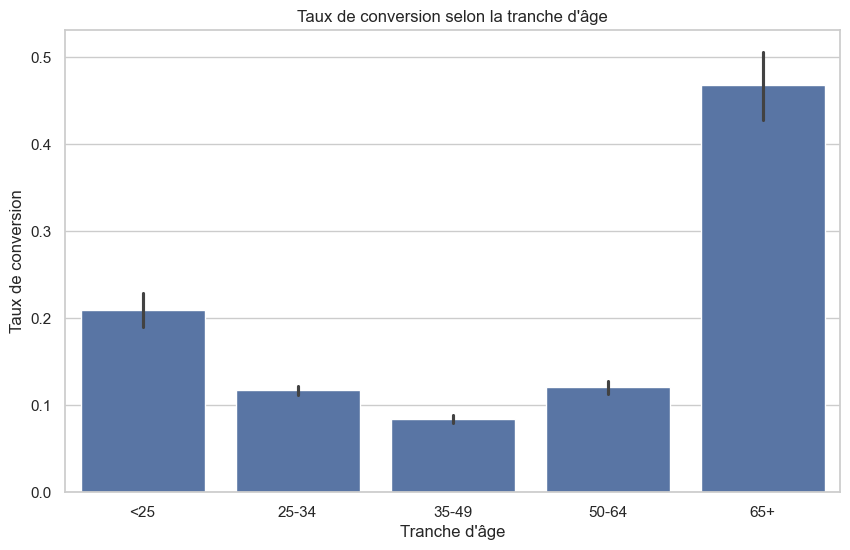

In [37]:
# 2. Taux de conversion par tranche d'âge
plt.figure()
sns.barplot(
    data=dt,
    x='age_bin',
    y='y_bin',
    estimator='mean',
    order= ['<25','25-34','35-49','50-64','65+']
)
plt.title("Taux de conversion selon la tranche d'âge")
plt.ylabel("Taux de conversion")
plt.xlabel("Tranche d'âge")
plt.savefig(PLOTS_DIR / "Taux_de_conversion_selon_la_tranche_age.png", dpi=300, bbox_inches='tight')
plt.show()


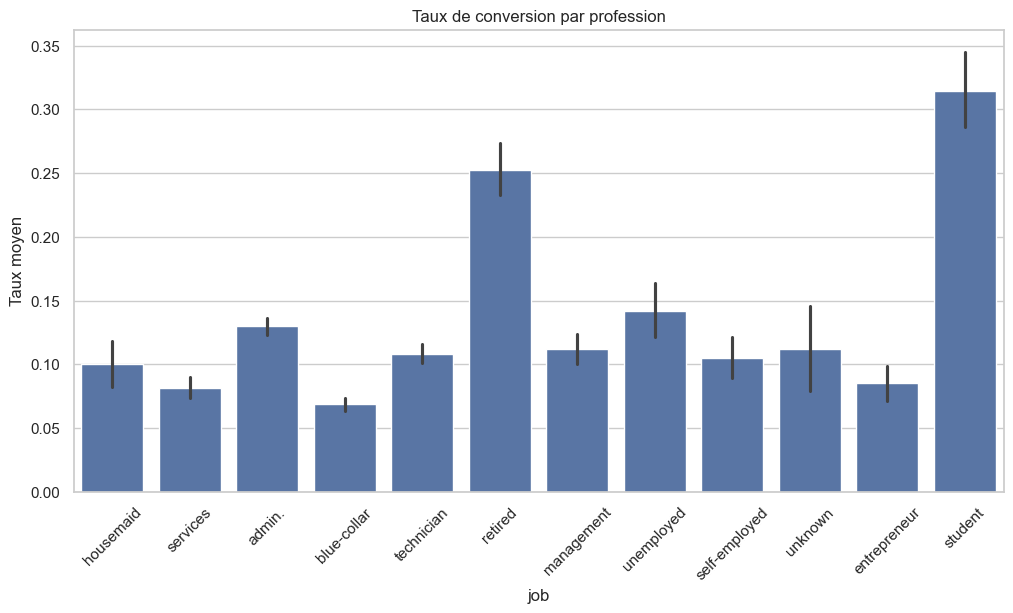

In [38]:
# 3. Taux de conversion par profession
plt.figure(figsize=(12,6))
sns.barplot(
    data=dt,
    x='job',
    y='y_bin',
    estimator='mean'
)
plt.title("Taux de conversion par profession")
plt.xticks(rotation=45)
plt.ylabel("Taux moyen")
plt.savefig(PLOTS_DIR/ "Taux de conversion par profession.png", dpi=300, bbox_inches='tight')
plt.show()

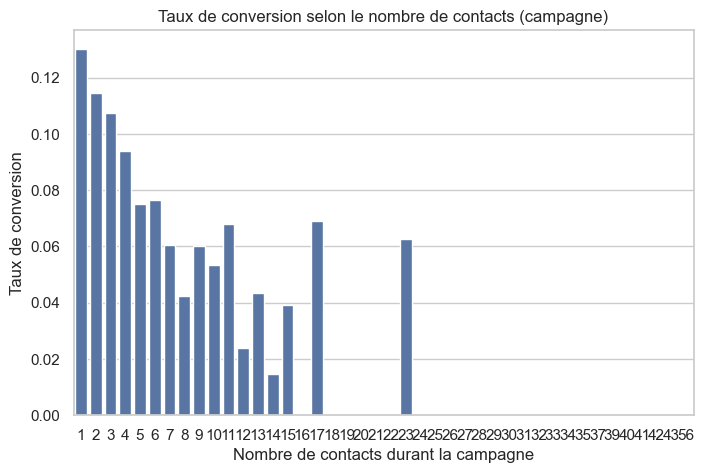

In [39]:
# 4. Taux de conversion selon le nombre de contacts (campagne)
plt.figure(figsize=(8,5))
sns.barplot(data=dt, x='campaign', y='y_bin', estimator='mean', ci=None)
plt.title("Taux de conversion selon le nombre de contacts (campagne)")
plt.xlabel("Nombre de contacts durant la campagne")
plt.ylabel("Taux de conversion")
plt.savefig(PLOTS_DIR / "Taux_conversion_selon_nb_contacts.png", dpi=300, bbox_inches='tight')
plt.show()

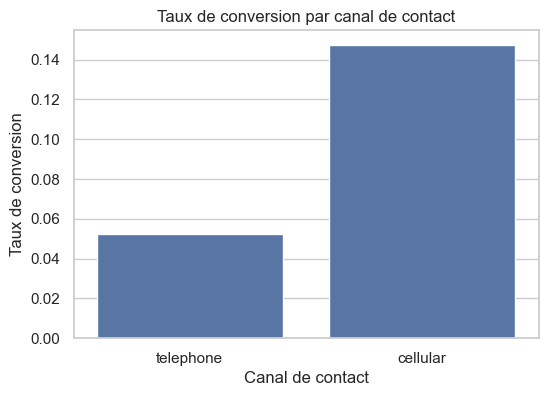

In [40]:
# 5. Taux de conversion par canal de contact
plt.figure(figsize=(6,4))
sns.barplot(data=dt, x='contact', y='y_bin', estimator='mean', ci=None)
plt.title("Taux de conversion par canal de contact")
plt.xlabel("Canal de contact")
plt.ylabel("Taux de conversion")
plt.savefig(PLOTS_DIR/ "Taux_conversion_par_canal_contact.png", dpi=300, bbox_inches='tight')
plt.show()

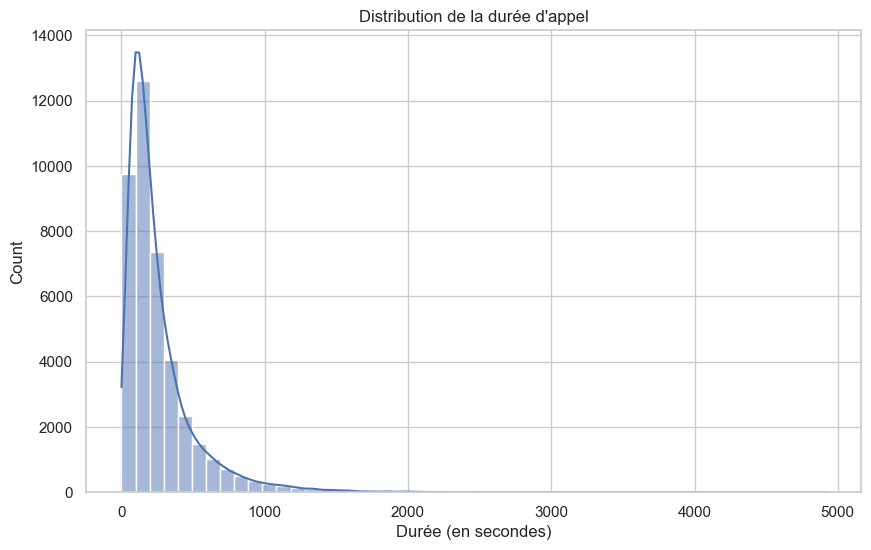

In [41]:
# 6. Durée d'appel : distribution
plt.figure()
sns.histplot(dt['duration'], bins=50, kde=True)     
plt.title("Distribution de la durée d'appel")
plt.xlabel("Durée (en secondes)")
plt.savefig(PLOTS_DIR/ "Distribution_de_la_durée_d'appel.png", dpi=300, bbox_inches='tight')
plt.show()


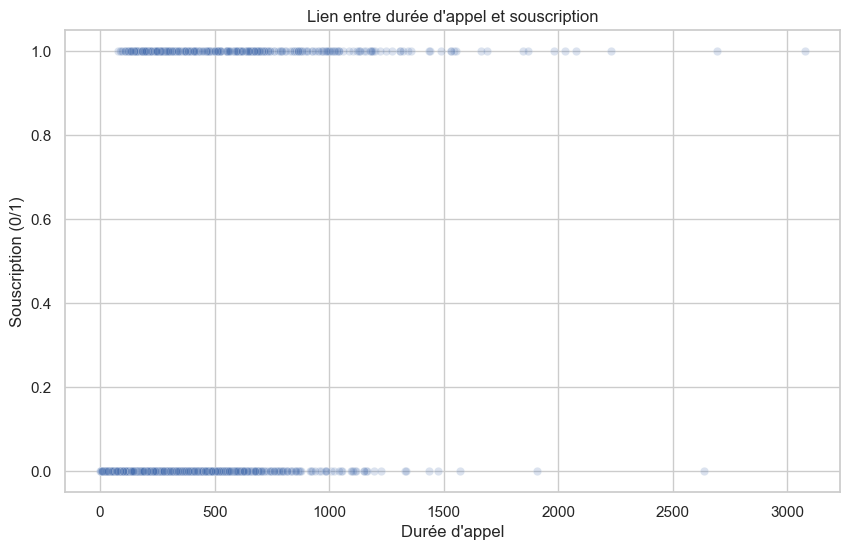

In [42]:
# 7. Relation durée vs probabilité
plt.figure()
sns.scatterplot(
    data=dt.sample(3000, random_state=123),
    x='duration',
    y='y_bin',
    alpha=0.2
)
plt.title("Lien entre durée d'appel et souscription")
plt.ylabel("Souscription (0/1)")
plt.xlabel("Durée d'appel")
plt.savefig(PLOTS_DIR / "Lien entre durée d'appel et souscription.png", dpi=300, bbox_inches='tight')
plt.show()


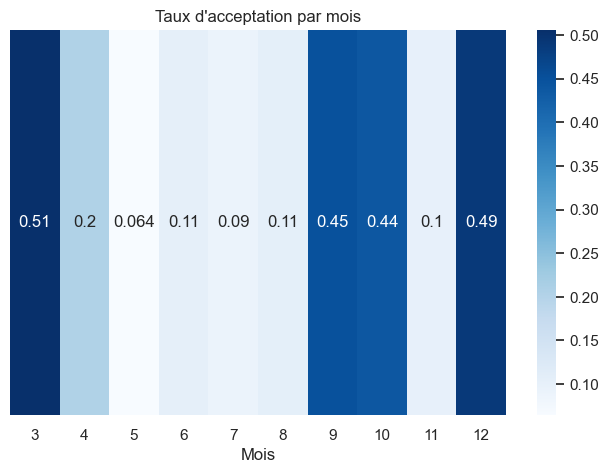

In [43]:
# 8. Conversion par mois de campagne
tmp = dt.groupby(['month_num'])['y_bin'].mean()

plt.figure(figsize=(8,5))
sns.heatmap(tmp.to_frame().T, annot=True, cmap="Blues")
plt.title("Taux d'acceptation par mois")
plt.yticks([])
plt.xlabel("Mois")
plt.savefig(PLOTS_DIR / "Taux d'acceptation par mois.png", dpi=300, bbox_inches='tight')
plt.show()


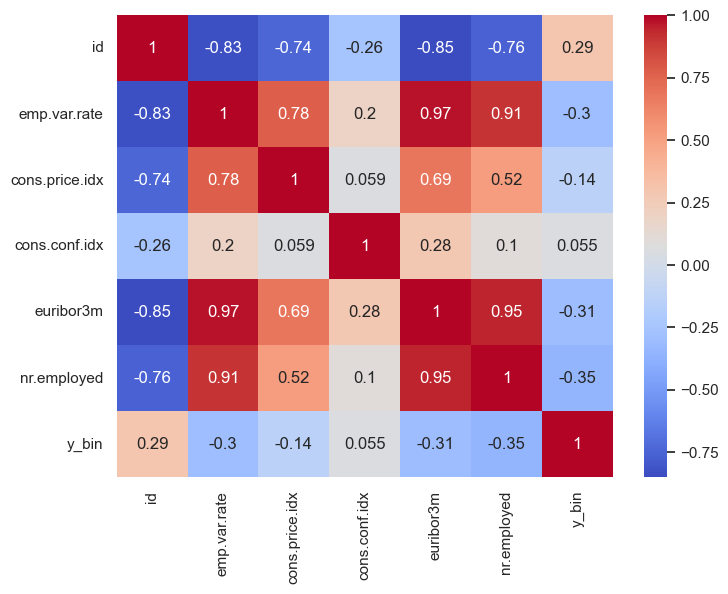

In [44]:

# 9. Corrélation macro-économie vs acceptation
plt.figure(figsize=(8,6))
sns.heatmap(dt[macro_cols + ['y_bin']].corr(), annot=True, cmap="coolwarm")
plt.savefig(PLOTS_DIR / "Corrélation macro-économie vs acceptation.png", dpi=300, bbox_inches='tight')
plt.show()
